
# CAN MDF Log analysis. Intro
 example of usage asammdf library to perform next tasks:
 - [x] read unsorted mdf raw log file
 - [x] extract specific message using dbc file for further analysis 
 - [x] extract multiple messages using multiple dbc files from multiple log files
 - [ ] extract common info of the messages
 - [ ] extract DM01 messages
 - [x] extract CAN bus messages for statistics analysis
    - [x]  group messages by CAN BUS, ID, extended flag
    - [ ] use appropriate storage format (Parquet data lake)
    - [x] validate outputs vs CANALYZER 
- [ ] Dashboards, reports and apps for express analysis
    * vehicle health status
    * feature specific analysis
    * chatGPT analysis

 ## Links and references

 ### MDF format
 * https://www.asam.net/standards/detail/mdf/wiki/
 * https://www.csselectronics.com/pages/mf4-mdf4-measurement-data-format
 
 ### asammdf python package to work with MDF
 * https://github.com/danielhrisca/asammdf
 * https://asammdf.readthedocs.io/en/latest/api.html

 ### other packages to work with CAN
see good collection in https://gist.github.com/jackm/f33d6e3a023bfcc680ec3bfa7076e696 

specific for CAN:
* https://github.com/hardbyte/python-can
* https://github.com/juergenH87/python-can-j1939
* https://github.com/milhead2/python-j1939

### Highlights about MDf and CAN DataFrame  
from https://www.csselectronics.com/pages/mf4-mdf4-measurement-data-format

> Note: MDF "channels" should not be confused with "bus channels" (the CANedge e.g. has 2 x CAN and 2 x LIN "bus channels").

If you're logging raw CAN bus data via "bus channel" 1 on the CANedge, the data will be stored in Channel Group 1 and 2. Here, CG 2 enables the use of variable data length (necessary for e.g. CAN FD).

Within CG 1, you'll see the CN CAN_DataFrame. This is split in 7 parts/sub channels:

BusChannel: The bus channel that the data is from
* ID: The CAN ID
* IDE: The ID type (regular, extended)
* DLC: The CAN frame DLC
* DataLength: The actual data length (may differ from the DLC for CAN FD)
* DataBytes: The data bytes of the CAN frame
* Dir: The direction (received, transmitted)


In [1]:
# imports and example settings
from asammdf import MDF
from cantools import db
import canmatrix.formats
import pandas as pd
from collections import defaultdict
from etils import ecolab
import matplotlib.pyplot as plt
import numpy as np
from asammdf.blocks import v4_constants as v4c
from asammdf.blocks import bus_logging_utils
import sys
import os
# example of mdf and dbc
mdf_path = r"input\canlog_38837_20241003_113923_move.mf4"
dbc_path = r"dbc\DTS_Status1.dbc"

ldf is not supported
xls is not supported
xlsx is not supported


# read unsorted mdf raw log file

In [2]:
# just сreate MDF object and create dbc map to channels
mdf = MDF(mdf_path)
databases = {
    "CAN": [(dbc_path, 2)], # map to channel 2 - Body CAN
    #  "CAN": [(dbc_path, 1),(dbc_path, 2)], # example of mapping to multiple CAN bus channels
}

# Extract selected message from log using DBC

In [3]:
# Extract selected message and transform to dataframe
mdf_extracted = mdf.extract_bus_logging(database_files=databases)
mdf_extracted_df=mdf_extracted.to_dataframe()
mdf_extracted_df.head()

,DTS_BrkPedlPosn,DTS_VehicleSpeed,DTS_AccrPedlPosn,DTS_Status1_checksum,DTS_Status1_counter,DT_ReadyToSleep,DTS_SystemStatus,DTS_AccrPedlSw,DTS_IgnitionStatus,DTS_BrkPedlSw,DTS_VehMoveDir,DTS_ReadyToSleep,DTS_ReadyToDrive
timestamps,,,,,,,,,,,,,
0.000000,100.0,41.21,0.0,137,9,b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'FORWARD',b'NOT_READY',b'READY'
0.050137,100.0,40.77,0.0,208,10,b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'FORWARD',b'NOT_READY',b'READY'
0.100196,100.0,40.33,0.0,27,10,b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'FORWARD',b'NOT_READY',b'READY'
0.150192,100.0,39.91,0.0,101,10,b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'FORWARD',b'NOT_READY',b'READY'
0.200211,100.0,39.45,0.0,9,10,b'NOT_READY',b'On',b'Pedal Released',b'ON',b'Pedal Depressed',b'FORWARD',b'NOT_READY',b'READY'


In [4]:
# Iterate through the extracted CAN messages.signals and print them
# Signals are represented in mdf as separate channels
for can_signal in mdf_extracted:
    print(can_signal.display_names)

{'CAN2.DTS_Status1.DT_ReadyToSleep': 'bus', 'DTS_Status1.DT_ReadyToSleep': 'message'}
{'CAN2.DTS_Status1.DTS_SystemStatus': 'bus', 'DTS_Status1.DTS_SystemStatus': 'message'}
{'CAN2.DTS_Status1.DTS_AccrPedlSw': 'bus', 'DTS_Status1.DTS_AccrPedlSw': 'message'}
{'CAN2.DTS_Status1.DTS_BrkPedlPosn': 'bus', 'DTS_Status1.DTS_BrkPedlPosn': 'message'}
{'CAN2.DTS_Status1.DTS_IgnitionStatus': 'bus', 'DTS_Status1.DTS_IgnitionStatus': 'message'}
{'CAN2.DTS_Status1.DTS_BrkPedlSw': 'bus', 'DTS_Status1.DTS_BrkPedlSw': 'message'}
{'CAN2.DTS_Status1.DTS_VehicleSpeed': 'bus', 'DTS_Status1.DTS_VehicleSpeed': 'message'}
{'CAN2.DTS_Status1.DTS_AccrPedlPosn': 'bus', 'DTS_Status1.DTS_AccrPedlPosn': 'message'}
{'CAN2.DTS_Status1.DTS_VehMoveDir': 'bus', 'DTS_Status1.DTS_VehMoveDir': 'message'}
{'CAN2.DTS_Status1.DTS_ReadyToSleep': 'bus', 'DTS_Status1.DTS_ReadyToSleep': 'message'}
{'CAN2.DTS_Status1.DTS_ReadyToDrive': 'bus', 'DTS_Status1.DTS_ReadyToDrive': 'message'}
{'CAN2.DTS_Status1.DTS_Status1_checksum': 'bus

In [5]:
# get specific signal selection using signal name
# all variants gives equal results because message name and signal are specific and unique in extracted mdf,
# onle 1 CAN channel was extracted (because of DBC map)
# mdf_extracted.get('DTS_VehicleSpeed')
# mdf_extracted.get('DTS_Status1.DTS_VehicleSpeed')
DTS_VehicleSpeed=mdf_extracted.get('CAN2.DTS_Status1.DTS_VehicleSpeed');

<Signal CAN2.DTS_Status1.DTS_VehicleSpeed:
	samples=[41.21 40.77 40.33 ... 22.72 23.02 23.33]
	timestamps=[2.19020270e-02 7.20387120e-02 1.22098394e-01 ... 6.09749256e+01
 6.10258953e+01 6.10749029e+01]
	invalidation_bits=None
	unit="km/h"
	conversion=None
	source=<asammdf.blocks.source_utils.Source object at 0x0000020667E7A070>
	comment="Signed Vehicle Speed"
	flags="0"
	mastermeta="('time', 1)"
	raw=False
	display_names={'CAN2.DTS_Status1.DTS_VehicleSpeed': 'bus', 'DTS_Status1.DTS_VehicleSpeed': 'message'}
	attachment=None>

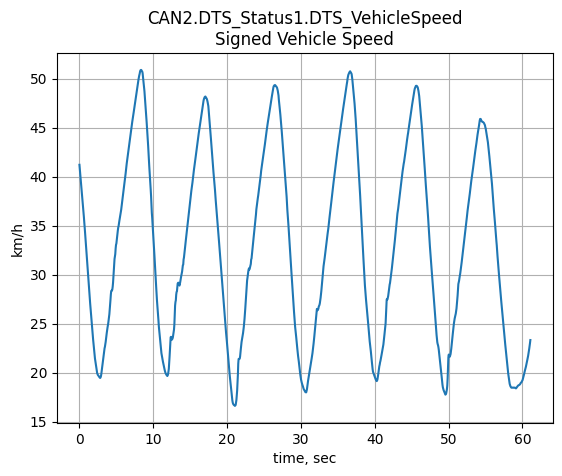

In [ ]:
# plot 
# using buildin APP GUI -  DTS_VehicleSpeed.plot(). It will launch separate APP
# TODO - get correct time units from data - seconds or what is it
plt.plot(DTS_VehicleSpeed.timestamps,DTS_VehicleSpeed.samples)
plt.grid(1)
plt.ylabel(DTS_VehicleSpeed.unit)
plt.xlabel('time, sec')
plt.title(list(DTS_VehicleSpeed.display_names.keys())[0]+'\n'+DTS_VehicleSpeed.comment)
plt.show()

# source address
DTS_VehicleSpeed.source.get_details();
DTS_VehicleSpeed.source.name;


In [7]:
## TODO: placeholder for example - use multiple DBC and MDF files

# extract CAN bus messages for statistics analysis
Data is grouped into channels that is described in separate section of MDF. See MDF ref. materials.
For CAN bus messages, the following fields need to be extracted for analysis:
- Timestamps - for time statistics analysis
- CAN ID and J1939.PGN where its J1939 
- CAN Data


In [8]:
# print example of channels names
all_channels=[]
for group in mdf.groups:
    print(group)
    for channel in group['channels']:
        print(channel.name)

CAN_DataFrame
CAN_DataFrame.DataBytes
CAN_DataFrame.BusChannel
CAN_DataFrame.Flags
CAN_DataFrame.EDL
CAN_DataFrame.ESI
CAN_DataFrame.BRS
CAN_DataFrame.ID
CAN_DataFrame.IDE
CAN_DataFrame.DLC
CAN_DataFrame.DataLength
t
CAN_DataFrame
CAN_DataFrame.DataBytes
CAN_DataFrame.BusChannel
CAN_DataFrame.Flags
CAN_DataFrame.EDL
CAN_DataFrame.ESI
CAN_DataFrame.BRS
CAN_DataFrame.ID
CAN_DataFrame.IDE
CAN_DataFrame.DLC
CAN_DataFrame.DataLength
t
CAN_DataFrame
CAN_DataFrame.DataBytes
CAN_DataFrame.BusChannel
CAN_DataFrame.Flags
CAN_DataFrame.EDL
CAN_DataFrame.ESI
CAN_DataFrame.BRS
CAN_DataFrame.ID
CAN_DataFrame.IDE
CAN_DataFrame.DLC
CAN_DataFrame.DataLength
t
CAN_DataFrame
CAN_DataFrame.DataBytes
CAN_DataFrame.BusChannel
CAN_DataFrame.Flags
CAN_DataFrame.EDL
CAN_DataFrame.ESI
CAN_DataFrame.BRS
CAN_DataFrame.ID
CAN_DataFrame.IDE
CAN_DataFrame.DLC
CAN_DataFrame.DataLength
t
CAN_DataFrame
CAN_DataFrame.DataBytes
CAN_DataFrame.BusChannel
CAN_DataFrame.Flags
CAN_DataFrame.EDL
CAN_DataFrame.ESI
CAN_DataFrame

Next - extract ID (+PGN where possible), time stamps.
As base the original code from method MDF.extract_bus_logging is used, some methods

In [9]:
# Iterate over all groups and channels (CAN_DataFrame types)
# Create a list to store data for each CAN message
get_payload=False
def get_all_messages(mdf, get_payload=False):
    all_can_messages = []
    total_unique_ids = set()
    all_can_msgs=defaultdict(list)
    for i, group in enumerate(mdf.groups):
        # if (
        # not group.channel_group.flags & v4c.FLAG_CG_BUS_EVENT
        # or group.channel_group.acq_source.bus_type != v4c.BUS_TYPE_CAN
        # or 
        # not "CAN_DataFrame" in [ch.name for ch in group.channels]
        # ):
        #     continue
        
        mdf._prepare_record(group)
        data = mdf._load_data(group, optimize_read=False)
        for fragment in data:
                        mdf._set_temporary_master(None)
                        mdf._set_temporary_master(mdf.get_master(i, data=fragment))

                        bus_ids = mdf.get(
                            "CAN_DataFrame.BusChannel",
                            group=i,
                            data=fragment,
                        ).samples.astype("<u1")

                        msg_ids = mdf.get("CAN_DataFrame.ID", group=i, data=fragment).astype("<u4")
                        try:
                            msg_ide = mdf.get("CAN_DataFrame.IDE", group=i, data=fragment).samples.astype("<u1")
                        except:
                            msg_ide = (msg_ids & 0x80000000) >> 31

                        msg_ids &= 0x1FFFFFFF

                        data_bytes = mdf.get(
                            "CAN_DataFrame.DataBytes",
                            group=i,
                            data=fragment,
                        ).samples

                        buses = np.unique(bus_ids)
                        
                        for bus in buses:

                            idx_bus = np.argwhere(bus_ids == bus).ravel()
                            bus_t = msg_ids.timestamps[idx_bus]
                            bus_msg_ids = msg_ids.samples[idx_bus]
                            bus_msg_ide = msg_ide[idx_bus]
                            bus_data_bytes = data_bytes[idx_bus]

                            # tmp_pgn = bus_msg_ids >> 8
                            # ps = tmp_pgn & 0xFF
                            # pf = (bus_msg_ids >> 16) & 0xFF
                            # _pgn = tmp_pgn & 0x3FF00
                            # j1939_msg_pgns = np.where(pf >= 240, _pgn + ps, _pgn)
                            # j9193_msg_sa = bus_msg_ids & 0xFF

                            unique_ids = set(zip(bus_msg_ids.tolist(), bus_msg_ide.tolist()))

                            total_unique_ids = total_unique_ids | set(unique_ids)
                            for msg_id, is_extended in sorted(unique_ids):
                                idx_msg = np.argwhere((bus_msg_ids == msg_id) & (bus_msg_ide == is_extended)).ravel()
                                # payload = bus_data_bytes[idx]
                                msg_t = bus_t[idx_msg]
                                if is_extended:
                                    # Optional: only if working with J1939
                                    # try to extract J1939 attributes
                                    # TODO: create logic to distinguish CAN extended and J1939
                                    tmp_pgn = msg_id >> 8
                                    ps = tmp_pgn & 0xFF
                                    pf = (msg_id >> 16) & 0xFF
                                    _pgn = tmp_pgn & 0x3FF00
                                    msg_pgn = _pgn + ps if pf >= 240 else _pgn
                                    msg_sa = msg_id & 0xFF
                                else:
                                    msg_sa=None
                                    msg_pgn=None
                                    
                                if get_payload:
                                    payload = bus_data_bytes[idx_msg]
                                else:
                                    payload=None
                                    
                                out_msg={
                                'CAN_Bus': bus,
                                'msg_id': msg_id,
                                'is_extended': is_extended,
                                'msg_pgn': msg_pgn,  
                                'msg_sa': msg_sa,
                                'msg_time': msg_t,
                                'msg_data': payload
                                }
                                all_can_messages.append(out_msg)
                                all_can_msgs[(bus,msg_id, is_extended)].append(out_msg)
                                
    return (all_can_messages,all_can_msgs)
                
(all_can_messages,all_can_msgs) = get_all_messages(mdf,False)
all_can_messages_df=pd.DataFrame(all_can_messages)
all_can_messages_df.count();
all_can_messages_df.head();

CAN_Bus        838
msg_id         838
is_extended    838
msg_pgn        730
msg_sa         730
msg_time       838
msg_data         0
dtype: int64

,CAN_Bus,msg_id,is_extended,msg_pgn,msg_sa,msg_time,msg_data
0,0,284222538,1,61668.0,74.0,"[0.646037634, 1.6460495380000002, 2.64619078, ...",None
1,1,168820993,1,135168.0,1.0,"[0.063135961, 0.16298131100000002, 0.263013003...",None
2,1,217068963,1,61493.0,163.0,"[0.9389590400000001, 1.939050613, 2.939298194,...",None
3,2,32908311,1,128548.0,23.0,"[0.414034086, 1.414025322, 2.414106561, 3.4140...",None
4,2,32908966,1,128550.0,166.0,"[0.23288392300000002, 1.232951495, 2.233053403...",None


In [10]:
# export all can messages to csv and excel
# if export directly as it is - there would be ellipsis ... for long numpy data.
# need to setup numpy, see explanations here https://stackoverflow.com/questions/25375260/pandas-to-csv-always-substitute-long-numpy-ndarray-with-ellipsis
np.set_printoptions(threshold=sys.maxsize)
all_can_messages_df.to_excel(r'output/all_can_messages_df.xlsx')
all_can_messages_df.to_csv(r'output/all_can_messages_df.csv')
file_sz_csv=os.path.getsize('output/all_can_messages_df.csv')
file_sz_xlsx=os.path.getsize('output/all_can_messages_df.xlsx')
print(f'File Sizes in MegaBytes CSV vs XLSX: {file_sz_csv/ (1024 * 1024):.2f} vs {file_sz_xlsx/ (1024 * 1024):.2f} ')


File Sizes in MegaBytes CSV vs XLSX: 7.25 vs 1.89 


# Validate outputs vs Vector CANALYZER

In [11]:
# read data
vector_data_file=r'input\CANALYZER__EXPORT_canlog_38837_20241003_113923_move_CAN2_DTS_Status1.csv'
vector_data_df=pd.read_csv(vector_data_file)

In [12]:
# compare timestamps
time0_ethalon=vector_data_df["Time[s]"].values
all_can_df=all_can_messages_df[(all_can_messages_df["msg_pgn"]==129537) & (all_can_messages_df["CAN_Bus"]==2)]
time1_extracted_all=all_can_df["msg_time"].values[0]
time2_extracted_msg=DTS_VehicleSpeed.timestamps

print_diff_stat= lambda s,d:print(f'{s}:\nmin {d.min()} max {d.max()} mean {d.mean()}')

diff1=time0_ethalon-time1_extracted_all
diff2=time0_ethalon-time2_extracted_msg
diff3=time1_extracted_all-time2_extracted_msg
# print(f'min {diff1.min()} max {diff1.max()} mean {diff1.mean()}')
print('statistics on timestamps diff:')
print_diff_stat('vector ethalon vs extracted all msgs' ,diff1)
print_diff_stat('vector ethalon vs extracted dbc msgs',diff2)
print_diff_stat('all msgs vs dbc msg' ,diff3)


# compare values
values0_ethalon=vector_data_df["DTS_Status1::DTS_Status1::DTS_VehicleSpeed[km/h]"].values
# values1 - no extracted values
values2_extracted_msg=DTS_VehicleSpeed.samples

diff2=values0_ethalon-values2_extracted_msg

print('\n\nstatistics on speed values diff:')
print_diff_stat('vector ethalon vs extracted dbc msgs',diff2)

statistics on timestamps diff:
vector ethalon vs extracted all msgs:
min -4.990000022075947e-07 max 4.989999995430594e-07 mean 6.95908149972846e-09
vector ethalon vs extracted dbc msgs:
min -4.990000022075947e-07 max 4.989999995430594e-07 mean 6.95908149972846e-09
all msgs vs dbc msg:
min 0.0 max 0.0 mean 0.0


statistics on speed values diff:
vector ethalon vs extracted dbc msgs:
min -3.552713678800501e-14 max 2.1316282072803006e-14 mean -7.0094866445073714e-15


# Extract DM01 message from the log
next files would be used as references:
* CANALYZER__EXPORT_canlog_38837_20241003_113923_move_CAN2_DM01_SA_5A.csv - CAN2 trace with DM01 message with Source Address = 0x5A (DCU) from Vector Canalyzer
* DTC_EXPORT_canlog_38837_20241003_113923_move.xlsx - decoded diagnostics message for later analysis
DM01 PGN = 0xFECA=65226

In [13]:
DM01_pgn=65226
DM01_ref=pd.read_csv(r'input/CANALYZER__EXPORT_canlog_38837_20241003_113923_move_CAN2_DM01_SA_5A.csv')
DM01_ref.head()


,Time[s],j1939::DM01::MILStatus,j1939::DM01::AWLStatus,j1939::DM01::RSLState,j1939::DM01::PLStatus,j1939::DM01::DTC5,j1939::DM01::DTC4,j1939::DM01::DTC3,j1939::DM01::DTC2,j1939::DM01::DTC1
0,0.833994,0,0,1,0,30415488,18154370,17504711,31778760,31647877
1,1.833996,0,0,1,0,30415488,18154370,17504711,31778760,31647877
2,2.834154,0,0,1,0,30415488,18154370,17504711,31778760,31647877
3,3.834005,0,0,1,0,30415488,18154370,17504711,31778760,31647877
4,4.834139,0,0,1,0,30415488,18154370,17504711,31778760,31647877


Now lets try to read DM01 message using j1939_DM01.dbc where DM01 message is defined

In [14]:
dbc_path = r"dbc\j1939_DM01.dbc"
databases = {
    "CAN": [(dbc_path, 2)], # map to channel 2 - Body CAN
}
# Extract selected message and transform to dataframe
mdf_extracted = mdf.extract_bus_logging(database_files=databases)
print(mdf_extracted)
mdf_extracted_df=mdf_extracted.to_dataframe()
mdf_extracted_df.head()
mdf_cols=list(mdf_extracted_df.columns);

[]

empty, seems because DM worked with transport protocol and not supported yet
Now tru to find do we have such messages in exported all messages in all_can_messages_df

In [15]:
DM01_find=all_can_messages_df[(all_can_messages_df["msg_pgn"]==DM01_pgn)].sort_values(by=["msg_sa"])
DM01_find.head();
print('msg_sa=90')
DM01_find[DM01_find["msg_sa"]==90].head();

,CAN_Bus,msg_id,is_extended,msg_pgn,msg_sa,msg_time,msg_data
411,1,419351043,1,65226.0,3.0,"[0.715993249, 1.7159591500000002, 2.7159887200...",None
779,7,419351091,1,65226.0,51.0,"[0.256116346, 1.2593577340000002, 2.256552505,...",None
612,2,419351098,1,65226.0,58.0,"[0.826868782, 1.8270923620000001, 2.828053977,...",None
823,8,419351098,1,65226.0,58.0,"[0.8268831160000001, 1.8271096960000002, 2.826...",None
613,2,419351107,1,65226.0,67.0,"[0.9189577680000001, 1.924018242, 2.9289523760...",None


msg_sa=90


,CAN_Bus,msg_id,is_extended,msg_pgn,msg_sa,msg_time,msg_data


No messages with SA = 90 and CAN=2

In [16]:
df_sa90=all_can_messages_df[(all_can_messages_df["msg_sa"]==90) & (all_can_messages_df['CAN_Bus']==2)].sort_values(by=['msg_pgn'])
df_sa90.head();


,CAN_Bus,msg_id,is_extended,msg_pgn,msg_sa,msg_time,msg_data
582,2,418119514,1,60160.0,90.0,"[0.39394081000000003, 0.44800234600000005, 0.5...",None
593,2,418185050,1,60416.0,90.0,"[0.339087238, 1.339342486, 2.3381516660000004,...",None
603,2,418382170,1,61441.0,90.0,"[0.033985928000000006, 0.13394761600000002, 0....",None
604,2,418384218,1,61449.0,90.0,"[0.004924564, 0.055044249, 0.105013592, 0.1551...",None
449,2,15739738,1,61483.0,90.0,"[0.032898877, 0.13287589900000002, 0.232877589...",None


# Transport protocol implementation 

There's no DM01 from SA=90 because its trasmitted with Transport protocol.

See example below
![1939_DM01_TP_example.png](./attachment/J1939_DM01_TP_example.png)

next - try to get decode multiframe DM01 messages using next algorithm:
1. get TP.CM_BAM frame 
2. if field pgn == DM01_PGN,then  get number of next packets frames
3. collect packets as TP.TD frames and compose full DM01 message with all DTC

In [17]:
dbc_path = r"dbc\j1939.dbc"
# dbc = db.load_file(dbc_path,strict=False)
dbc = canmatrix.formats.loadp_flat(dbc_path)
target_messages = ["DM01", "TPCMxx","TPDT"]  # Replace with actual message names or CAN IDs
# target_msg={'DM01':'FECA', 'TPCMxx':'EC00','TPDT':'EB00'}
target_msg_pgn={'DM01':65226, 'TPCMxx':60416,'TPDT':60160}


# for num, frame in enumerate(dbc.frames):
#     print(f"Frame {num}: {frame}")
#     print(f" is j1939: {frame.is_j1939}")
#     print(f" id:  {frame.arbitration_id}")
#     # print(f' Format: {frame.attributes["VFrameFormat"]}')
#     if frame.is_j1939:
#         print(f" pgn: {hex(frame.arbitration_id.pgn)}")

# Convert message names to CAN IDs if needed
# target_msgs = []
filtered_matrix = canmatrix.CanMatrix()
for message_name in target_messages:
    message = dbc.frame_by_name(message_name)
    if message:
        # target_msgs.append(message)
        filtered_matrix.add_frame(message)
    else:
        print(f"Message '{message_name}' not found in DBC file.")
# print(target_msgs)

# for message_name in target_messages:
#     if message_name in dbc.frames:
#         target_msgs.append(dbc.frames[message_name])
#     else:
#         print(f"Message '{message_name}' not found in DBC file.")

# Extract selected message and transform to dataframe
# mdf_extracted = mdf.extract_bus_logging(database_files=databases)
# print(mdf_extracted)
# mdf_extracted_df=mdf_extracted.to_dataframe()
# mdf_extracted_df.head()
# mdf_cols=list(mdf_extracted_df.columns);

In [18]:
databases = {
    "CAN": [(filtered_matrix, 2)], # map to channel 2 - Body CAN
}
mdf_extracted = mdf.extract_bus_logging(database_files=databases)
print(mdf_extracted)
mdf_extracted_df=mdf_extracted.to_dataframe()
mdf_extracted_df.head()
# mdf_cols=list(mdf_extracted_df.columns);
for can_signal in mdf_extracted:
    print(can_signal.display_names)

# TPCMxx=mdf_extracted.get('CAN2.TPCMxx.PGNumber'); 
# wouldn't work because of multiple frames - need 

{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPDT.SequenceNumber': 'bus', 'TPDT.SequenceNumber': 'message'}
{'CAN2.TPCMxx.PGNumber': 'bus', 'TPCMxx.PGNumber': 'message'}
{'CAN2.TPCMxx.ControlByte': 'bus', 'TPCMxx.ControlByte': 'message'}
{'CAN2.TPCMxx.TotalMessageSizeBAM': 'bus', 'TPCMxx.TotalMessageSizeBAM': 'message'}
{'CAN2.TPCMxx.To

We could use extract_bus_logging but it could be not suitable for all cases.
Lets try to do it using raw data

In [19]:
# first - extract all messages with payload flag True to parse later
(all_can_messages,all_can_msgs) = get_all_messages(mdf,True)
all_can_messages_df=pd.DataFrame(all_can_messages)
all_can_messages_df.head();
# then we will try to select messages from CAN2 SA=90 with next PGN
target_msg_pgn;

,CAN_Bus,msg_id,is_extended,msg_pgn,msg_sa,msg_time,msg_data
0,0,284222538,1,61668.0,74.0,"[0.646037634, 1.6460495380000002, 2.64619078, ...","[[224], [225], [226], [227], [228], [229], [23..."
1,1,168820993,1,135168.0,1.0,"[0.063135961, 0.16298131100000002, 0.263013003...","[[225], [225], [225], [225], [225], [225], [22..."
2,1,217068963,1,61493.0,163.0,"[0.9389590400000001, 1.939050613, 2.939298194,...","[[253], [253], [253], [253], [253], [253], [25..."
3,2,32908311,1,128548.0,23.0,"[0.414034086, 1.414025322, 2.414106561, 3.4140...","[[255], [255], [255], [255], [255], [255], [25..."
4,2,32908966,1,128550.0,166.0,"[0.23288392300000002, 1.232951495, 2.233053403...","[[192], [192], [192], [192], [192], [192], [19..."


{'DM01': 65226, 'TPCMxx': 60416, 'TPDT': 60160}

In [20]:
# try to extract specific messages
msgs_find=all_can_messages_df[(all_can_messages_df["CAN_Bus"]==2) & (all_can_messages_df["msg_sa"]==90) & (all_can_messages_df["msg_pgn"]==target_msg_pgn["TPCMxx"])  ]
msgs_find.head();
payload=msgs_find['msg_data'].values[0][0];
time=msgs_find['msg_time'].values[0][0];

,CAN_Bus,msg_id,is_extended,msg_pgn,msg_sa,msg_time,msg_data
593,2,418185050,1,60416.0,90.0,"[0.339087238, 1.339342486, 2.3381516660000004,...","[[32, 58, 0, 9, 255, 202, 254, 0], [32, 58, 0,..."


array([ 32,  58,   0,   9, 255, 202, 254,   0], dtype=uint8)

0.339087238

In [21]:
# message=dbc.frame_by_name('TPCMxx')
# is_j1939=True
# is_extended=msgs_find['is_extended'].values[0];
# extracted_signals = bus_logging_utils.extract_mux(
#                                     payload,
#                                     message,
#                                     418185050,
#                                     2,
#                                     time,
#                                     original_message_id=90 if is_j1939 else None,
#                                     ignore_value2text_conversion=True,
#                                     is_j1939=is_j1939,
#                                     is_extended=is_extended,
#                                     raw=True,
#                                 )